This dataset brings together detailed 🍺 ratings and reviews, perfect for exploring and building machine learning models, captures over 10K+ beer reviews and ratings from beer enthusiasts around the world.

Whether you're curious about predicting beer ratings or uncovering trends in beer preferences, this dataset is your go-to resource.

What's Included:

The dataset, train.csv, contains the following columns:

--------------------------------------------------------------

index: Identifier for the review.

beer/ABV: Alcohol by volume of the beer.

beer/beerId: Unique ID for the beer reviewed.

beer/brewerId: Unique ID for the brewery.

beer/name: Name of the beer.

beer/style: Style/type of the beer.

review/appearance: Rating of the beer’s appearance (1.0 to 5.0).

review/aroma: Rating of the beer’s aroma (1.0 to 5.0).

review/overall: Overall rating of the beer (1.0 to 5.0).

review/palate: Rating of the beer’s palate (1.0 to 5.0).

review/taste: Rating of the beer’s taste (1.0 to 5.0).

review/text: Text of the review.

review/timeStruct: Structured timestamp for when the review was submitted.

review/timeUnix: Unix timestamp of the review.

user/ageInSeconds: Age of the user in seconds.

user/birthdayRaw: User’s raw birthday information.

user/birthdayUnix: Unix timestamp for the user’s birthday.

user/gender: Gender of the user (if specified).

user/profileName: Profile name of the user.

---------------------------------------------------

present the dataset:

what issues did you encounter or suspect with the quality of the data?

which brewery is producing the strongest beer? 

what factors are most influencing the overall beer rating?

If you had a beer store, what beers would you stock up?

How would you go about predicting future rating for a new beer?

In [1]:
import pandas as pd
from datetime import datetime, timezone
import numpy as np

import ast # to convert string dictionary to dictionary
import pytz # to set the correct timezone to align the birthdays timestamps

import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz, process

import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import xgboost as xgb

pd.set_option('display.max_columns', None)

C:\Users\Alienware\miniconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alienware\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
beer_df = pd.read_csv('train.csv')
beer_df

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.00,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.00,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.70,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.40,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.40,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,35175,5.50,22450,3268,Blackberry Scottish-Style,Fruit / Vegetable Beer,4.0,3.5,3.5,3.5,3.5,12 oz brown longneck with no freshness dating....,"{'min': 56, 'hour': 23, 'mday': 10, 'sec': 1, ...",1207871761,NaN,NaN,NaN,NaN,Redrover
37496,23666,8.50,7463,1199,Founders Dirty Bastard,Scotch Ale / Wee Heavy,4.5,4.0,3.5,4.5,4.5,A - A bright red with a maroon-amber hue; mini...,"{'min': 45, 'hour': 5, 'mday': 10, 'sec': 14, ...",1263102314,NaN,NaN,NaN,NaN,jmerloni
37497,47720,4.75,1154,394,Stoudt's Fest,MÃ¤rzen / Oktoberfest,4.0,3.5,4.0,4.5,4.0,Sampled on tap at Redbones.\t\tThis marzen sty...,"{'min': 3, 'hour': 1, 'mday': 25, 'sec': 36, '...",1067043816,NaN,NaN,NaN,NaN,UncleJimbo
37498,33233,11.20,19960,1199,Founders KBS (Kentucky Breakfast Stout),American Double / Imperial Stout,4.0,4.0,4.0,5.0,5.0,Pours a black body with a brown head that very...,"{'min': 52, 'hour': 19, 'mday': 29, 'sec': 33,...",1296330753,NaN,NaN,NaN,NaN,Stockfan42


In [3]:
# checking if all elements of the 'index' column are unique: we can set this columns as index

if beer_df['index'].nunique() == beer_df.shape[0]: 
    beer_df.set_index(['index'], inplace=True)
    print('column "index" set as new index')

column "index" set as new index


In [4]:
# checking if the column 'beer/beerId' corresponds to the columns 'beer/name'

beer_id_to_beer_name = beer_df.groupby('beer/beerId')['beer/name'].nunique()

if (beer_id_to_beer_name == 1).all(): # Each ID corresponds to exactly one beer name
    beer_df.drop('beer/beerId', axis=1, inplace=True)
    print('Each ID corresponds to exactly one beer name, so we can drop the column "beer/beerId"')


Each ID corresponds to exactly one beer name, so we can drop the column "beer/beerId"


In [5]:
# check if the field 'review/timeStruct' corresponds to the field 'review/timeUnix'

# transform the time structured string field to a datetime and then to another unix timestamp
def timestruct_to_timestamp(t):
    # If t is a string, convert it to a dictionary using ast.literal_eval
    if isinstance(t, str):
        t = ast.literal_eval(t)
    dt = datetime(t['year'], t['mon'], t['mday'], t['hour'], t['min'], t['sec'])
    return dt

# create the review datetime
beer_df['review/datetime'] = beer_df['review/timeStruct'].apply(timestruct_to_timestamp)

# derive the review unix timestamp from it
beer_df['review/timestamp'] = beer_df['review/datetime'].apply(lambda x: int(x.timestamp()))

# drop the timeStruct field
beer_df.drop('review/timeStruct', axis=1, inplace=True)

# compute a new column with the absolute difference between the two reviews timestamp columns 
beer_df['review/timediff'] = abs(beer_df['review/timestamp'] - beer_df['review/timeUnix'])

# check the value counts of the absolute difference between the two reviews timestamp columns
print(beer_df['review/timediff'].value_counts())

# there is no difference, so we can drop these fields and keep only the 'review/datetime'
beer_df.drop(['review/timestamp', 'review/timediff', 'review/timeUnix'], axis=1, inplace=True)

review/timediff
0    37500
Name: count, dtype: int64


In [6]:
# check if the field 'user/birthdayRaw' corresponds to the field 'user/birthdayUnix'

# Convert the raw birthday field to a datetime and drop the original raw one
beer_df['user/birthday'] = pd.to_datetime(beer_df['user/birthdayRaw'], format="%b %d, %Y")
beer_df.drop('user/birthdayRaw', axis=1, inplace=True)

# Choose the appropriate local timezone (US Pacific selected to match the 'user/birthdayTimestamp' field (calculated below) with the 'user/birthdayUnix' field
# (eight hours of difference would appear otherwise)
local_tz = pytz.timezone("America/Los_Angeles")

# Create the Unix timestamp, using the local timezone
beer_df['user/birthdayTimestamp'] = beer_df['user/birthday'].apply(
    lambda x: int(local_tz.localize(x).timestamp()) if pd.notna(x) else None
)
# compute a new column with the absolute difference between the two birthday timestamp columns 
beer_df['birthday/timediff'] = abs(beer_df['user/birthdayUnix'] - beer_df['user/birthdayTimestamp'])

# check the value counts of the absolute difference between the two birthday timestamp columns
print(beer_df['birthday/timediff'].value_counts())

# 62 records present a 420 seconds difference (analyzed below)

beer_df.loc[beer_df['birthday/timediff'] == 420.0, ['user/birthday']].sort_values(by='user/birthday')

# The 7-minute offset occurs because before standardized time zones were adopted, local mean time was used, which often differed from UTC by a few minutes. (?)

birthday/timediff
0.0      7794
420.0      62
Name: count, dtype: int64


,user/birthday
index,
28667,1900-01-01
43479,1900-01-01
22760,1900-01-01
36421,1900-01-01
46191,1900-01-01
...,...
28555,1901-06-16
6088,1901-06-16
30851,1901-06-16


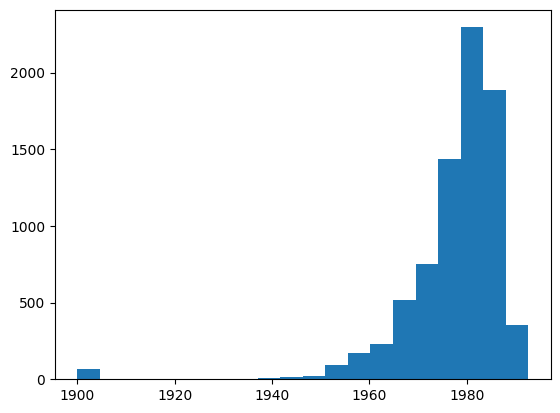

In [7]:
# these fields appear odd, because of the year of the user birthday (1900, 1901)
# it's clearly visible that they are outliers from the histogram below

plt.hist(beer_df['user/birthday'], bins=20)

# I decide to set these dates to NaT
beer_df.loc[beer_df['birthday/timediff'] == 420.0, 'user/birthday'] = pd.NaT


C:\Users\Alienware\AppData\Local\Temp\ipykernel_35036\2097174116.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beer_df.groupby('user/age_range')['user/profileName'].nunique()


user/age_range
-20        35
20-30    1021
30-40     450
40-50     132
50-60      40
60+        12
Name: user/profileName, dtype: int64

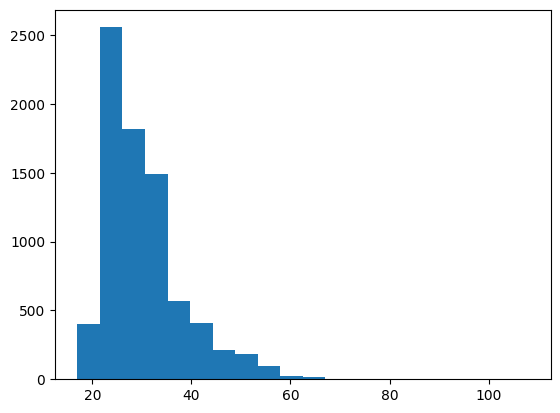

In [8]:
# I calculate the user age correctly, in years, at the time of the review

beer_df['user/age_atReview'] = ((beer_df['review/datetime'] - beer_df['user/birthday']).dt.days // 365)

plt.hist(beer_df['user/age_atReview'],bins=20)

# Defining some age bins, for a more detailed age analysis
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ["-20", "20-30", "30-40", "40-50", "50-60", "60+"]

beer_df['user/age_range'] = pd.cut(beer_df['user/age_atReview'], bins=bins, labels=labels)

# If one user appears multiple times (multiple reviews), I count unique users per bin.
beer_df.groupby('user/age_range')['user/profileName'].nunique()

In [9]:
# I suppose that the field 'user/ageInSeconds' has been wrongly calculated subtracting the 'user/birthday' from the datetime of calculation (at that time)
# to verify that, I derive the datetime of calculation and verify that a unique date is coming out from:

beer_df['datetime_of_calculations'] = beer_df['user/birthday'] + pd.to_timedelta(beer_df['user/ageInSeconds'], unit='s')
print(beer_df['datetime_of_calculations'].value_counts())

# the date of calculation is in fact the 2014-12-11
# differences (14:04:07, 14:04:08, 15:04:07, 15:04:08) could arise from inconsistent timezone/DST adjustments during conversion

# so the 'user/ageInSeconds' field is wrongly calculated and we can drop it, along with the birthdays in unix time, and the other calculated fields
beer_df.drop(['user/ageInSeconds', 'user/birthdayUnix', 'user/birthdayTimestamp', 'birthday/timediff', 'datetime_of_calculations'], axis=1, inplace=True)

beer_df

datetime_of_calculations
2014-12-11 15:04:07    3670
2014-12-11 14:04:07    2993
2014-12-11 14:04:08     646
2014-12-11 15:04:08     485
Name: count, dtype: int64


C:\Users\Alienware\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
C:\Users\Alienware\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in multiply
  return bound(*args, **kwds)


,beer/ABV,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/gender,user/profileName,review/datetime,user/birthday,user/age_atReview,user/age_range
index,,,,,,,,,,,,,,,,
40163,5.00,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,NaN,RblWthACoz,2008-12-16 03:38:10,NaT,NaN,NaN
8135,11.00,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,NaN,BeerSox,2008-08-08 23:38:58,NaT,NaN,NaN
10529,4.70,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,Male,mschofield,2004-11-26 18:07:02,NaT,NaN,NaN
44610,4.40,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,Male,molegar76,2011-06-20 01:07:05,1976-08-10,34.0,30-40
37062,4.40,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,NaN,Brewbro000,2011-03-12 06:51:48,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35175,5.50,3268,Blackberry Scottish-Style,Fruit / Vegetable Beer,4.0,3.5,3.5,3.5,3.5,12 oz brown longneck with no freshness dating....,NaN,Redrover,2008-04-10 23:56:01,NaT,NaN,NaN
23666,8.50,1199,Founders Dirty Bastard,Scotch Ale / Wee Heavy,4.5,4.0,3.5,4.5,4.5,A - A bright red with a maroon-amber hue; mini...,NaN,jmerloni,2010-01-10 05:45:14,NaT,NaN,NaN
47720,4.75,394,Stoudt's Fest,MÃ¤rzen / Oktoberfest,4.0,3.5,4.0,4.5,4.0,Sampled on tap at Redbones.\t\tThis marzen sty...,NaN,UncleJimbo,2003-10-25 01:03:36,NaT,NaN,NaN


In [53]:
# using fuzzy matching to reduce the number of categories in the 'beer/style' field

# similarity threshold (quite low here, to get a small number of main categories)
threshold = 30

unique_styles = beer_df['beer/style'].dropna().unique()

sub_styles = {}   # will map each detailed style (sub_style) to its main style
main_styles = []  # the few styles, acting as the main styles

for sub_style in unique_styles:
    assigned = False
    # Compare current sub_style to each main_style already recorded
    for main_style in main_styles:
        score = fuzz.token_sort_ratio(sub_style, main_style)
        if score >= threshold:
            sub_styles[sub_style] = main_style # dictionary {sub_style_1 : main_style1 , sub_style_2 : main_style_1 , ... }
            assigned = True
            break
    if not assigned:
        # Add the sub style (which is the main style in this case) to the list and map it to itself
        main_styles.append(sub_style)
        sub_styles[sub_style] = sub_style

sub_styles

# # use the generated dictionary to map each beer/style value to its main style to create the new column with a reduced number of style categories.
# beer_df['beer/style_reduced'] = beer_df['beer/style'].map(sub_styles)
# beer_df['beer/style_reduced'].nunique()

# # note: once a style is assigned to a canonical label, later on it’s only compared against that fixed list, so it might not be re‑evaluated against other potential clusters.
# sub_styles

{'Herbed / Spiced Beer': 'Herbed / Spiced Beer',
 'American Barleywine': 'American Barleywine',
 'American Pale Ale (APA)': 'Herbed / Spiced Beer',
 'Czech Pilsener': 'Herbed / Spiced Beer',
 'English Pale Ale': 'English Pale Ale',
 'Russian Imperial Stout': 'Herbed / Spiced Beer',
 'American Wild Ale': 'Herbed / Spiced Beer',
 'Pumpkin Ale': 'American Barleywine',
 'English Barleywine': 'American Barleywine',
 'American IPA': 'American Barleywine',
 'Scotch Ale / Wee Heavy': 'Herbed / Spiced Beer',
 'American Double / Imperial Stout': 'American Barleywine',
 'Euro Pale Lager': 'Herbed / Spiced Beer',
 'Maibock / Helles Bock': 'Herbed / Spiced Beer',
 'American Amber / Red Ale': 'Herbed / Spiced Beer',
 'Rye Beer': 'Herbed / Spiced Beer',
 'American Double / Imperial IPA': 'American Barleywine',
 'MÃ¤rzen / Oktoberfest': 'American Barleywine',
 'Fruit / Vegetable Beer': 'Herbed / Spiced Beer',
 'Witbier': 'Witbier',
 'Light Lager': 'American Barleywine',
 'Rauchbier': 'Witbier',
 'Amer

In [11]:
# Define the bins and labels for beers with alcohol.
bins = [0, 5.5, 7.0, 9.5, np.inf]
labels = ['light', 'medium', 'strong', 'extra strong']

# Create the new ABV category column:
beer_df['beer/ABV_category'] = np.where(
    beer_df['beer/ABV'] == 0, 
    'no alcohol',  # If ABV is exactly zero (no records)
    pd.cut(beer_df['beer/ABV'], bins=bins, labels=labels)
)

beer_df['beer/ABV_category'].value_counts()


beer/ABV_category
light           10747
strong          10025
medium           9203
extra strong     7525
Name: count, dtype: int64

In [12]:
# checking if the profileName is a unique identifier for every user
print(beer_df['user/profileName'].nunique())

# checking if the combination of profileName and birthday is the unique identifier instead
print(beer_df[['user/profileName', 'user/birthday']].drop_duplicates().shape[0])

# we could create a unique user_id field as a concatenation of user_name and birthday, but let's check if it's necessary 

7441
7442


In [13]:
print(beer_df.groupby('user/profileName')['user/birthday'].nunique().sort_values(ascending=False))

# there are no user_id with two different birthdays, so probably one user could have added the birthday afterwards
# I suppose that there cannot be more users with the same profileName, then
# I drop the birthday column afterwards

beer_df.drop('user/birthday', axis=1, inplace=True)

user/profileName
0110x011         1
froggyfrog       1
fropones         1
fullsweep        1
funkengruven     1
                ..
bijanafx         0
bigrzman         0
IrishRedRock     0
IronCitySteve    0
fiver29          0
Name: user/birthday, Length: 7441, dtype: int64


In [14]:
# checking male and female reviews proportion 

beer_df['user/gender'].value_counts()

user/gender
Male      15069
Female      245
Name: count, dtype: int64

In [15]:
# which brewery is producing the strongest beer?

print(beer_df['beer/name'].nunique())

beer_df.groupby('beer/name')['beer/ABV'].mean().sort_values(ascending=False)

1688


beer/name
SchorschbrÃ¤u Schorschbock 57%    57.70
SchorschbrÃ¤u Schorschbock 43%    43.00
SchorschbrÃ¤u Schorschbock 40%    39.44
SchorschbrÃ¤u Schorschbock 31%    30.86
Schorschbock                      16.00
                                  ...  
Rege                               1.50
Okocim Karmi                       1.50
Bernard S &#269;istou Hlavou       0.50
Karmi Classic                      0.50
Amstel Malt                        0.10
Name: beer/ABV, Length: 1688, dtype: float64

In [16]:
strongest_beer = beer_df.groupby('beer/name')['beer/ABV'].mean().sort_values(ascending=False).index[0]
strongest_beer

'SchorschbrÃ¤u Schorschbock 57%'

In [17]:
beer_df[beer_df['beer/name'] == strongest_beer]

,beer/ABV,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/gender,user/profileName,review/datetime,user/age_atReview,user/age_range,beer/style_reduced,beer/ABV_category
index,,,,,,,,,,,,,,,,,
11997,57.7,6513,SchorschbrÃ¤u Schorschbock 57%,Eisbock,4.0,4.0,4.0,4.0,3.5,"New world strongest beer. Very limited, only 3...",NaN,kappldav123,2011-09-23 12:28:21,NaN,NaN,Doppelbock,extra strong


In [18]:
strongest_beer_brewery = beer_df[beer_df['beer/name'] == strongest_beer]['beer/brewerId'].iloc[0]
strongest_beer_brewery

6513

<Axes: xlabel='review/overall', ylabel='count'>

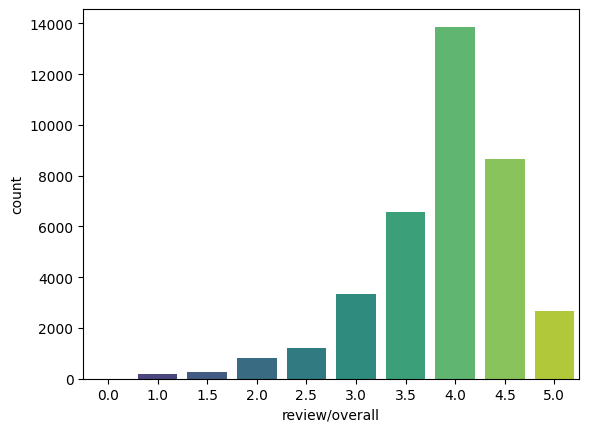

In [19]:
sns.countplot(x='review/overall', data=beer_df, palette='viridis')

In [20]:
# what factors are most influencing the overall beer rating?
# in order to identify the factors that influence the overall rating of the users, I use the relevant beer features 
# (except the ones related to the rating itself, as other ratings and comments)

cols = ['beer/ABV_category', 'beer/style_reduced',	'user/gender',	'user/age_range', 'review/overall']

for col in cols:
    print(beer_df[col].unique())

['light' 'extra strong' 'strong' 'medium']
['Herbed / Spiced Beer' 'American Barleywine' 'English Pale Ale' 'Witbier'
 'Hefeweizen' 'Braggot' 'Doppelbock' 'KÃ¶lsch' 'Milk / Sweet Stout']
[nan 'Male' 'Female']
[NaN, '30-40', '20-30', '50-60', '40-50', '-20', '60+']
Categories (6, object): ['-20' < '20-30' < '30-40' < '40-50' < '50-60' < '60+']
[4.  3.5 2.5 3.  4.5 2.  5.  1.5 1.  0. ]


In [21]:
# create categorical fields (ordered or nominal categories)

# beer/ABV_category: with increasing alcohol strength order
ordered_abv = ['light', 'medium', 'strong', 'extra strong']
beer_df['beer/ABV_category'] = pd.Categorical(beer_df['beer/ABV_category'], 
                                              categories=ordered_abv, 
                                              ordered=True)

# beer/style_reduced: a nominal variable
beer_df['beer/style_reduced'] = pd.Categorical(beer_df['beer/style_reduced'])

# user/gender: a nominal variable (plus a category for missing values)
beer_df['user/gender'] = beer_df['user/gender'].fillna('Unknown')
gender_categories = ['Female', 'Male', 'Unknown']
beer_df['user/gender'] = pd.Categorical(beer_df['user/gender'], categories=gender_categories)


# missing flag for age range (additionally to the ordinal categories), because of the many missing age ranges
beer_df['user/age_range_missing'] = beer_df['user/age_range'].isna().astype(int)

# Define the ordered categories
age_categories = ['-20', '20-30', '30-40', '40-50', '50-60', '60+']
# Convert to an ordered categorical with these categories:
beer_df['user/age_range_ord'] = pd.Categorical(beer_df['user/age_range'],
                                               categories=age_categories,
                                               ordered=True)


beer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 40163 to 23758
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   beer/ABV                37500 non-null  float64       
 1   beer/brewerId           37500 non-null  int64         
 2   beer/name               37500 non-null  object        
 3   beer/style              37500 non-null  object        
 4   review/appearance       37500 non-null  float64       
 5   review/aroma            37500 non-null  float64       
 6   review/overall          37500 non-null  float64       
 7   review/palate           37500 non-null  float64       
 8   review/taste            37500 non-null  float64       
 9   review/text             37490 non-null  object        
 10  user/gender             37500 non-null  category      
 11  user/profileName        37495 non-null  object        
 12  review/datetime         37500 non-null  datetim

In [22]:
# For ABV category
print("Mean review/overall by ABV category:")
print(beer_df.groupby('beer/ABV_category')['review/overall'].mean())

# For beer style (reduced)
print("\nMean review/overall by beer/style_reduced:")
print(beer_df.groupby('beer/style_reduced')['review/overall'].mean())

# For user gender
print("\nMean review/overall by user/gender:")
print(beer_df.groupby('user/gender')['review/overall'].mean())

# For user age range
print("\nMean review/overall by user/age_range:")
print(beer_df.groupby('user/age_range_ord')['review/overall'].mean())


Mean review/overall by ABV category:
beer/ABV_category
light           3.664883
medium          3.900033
strong          4.003142
extra strong    4.045714
Name: review/overall, dtype: float64

Mean review/overall by beer/style_reduced:
beer/style_reduced
American Barleywine     3.961841
Braggot                 3.627803
Doppelbock              3.934718
English Pale Ale        3.710832
Hefeweizen              3.736742
Herbed / Spiced Beer    3.861326
KÃ¶lsch                 3.883117
Milk / Sweet Stout      3.811321
Witbier                 3.836826
Name: review/overall, dtype: float64

Mean review/overall by user/gender:
user/gender
Female     3.989796
Male       3.902250
Unknown    3.879631
Name: review/overall, dtype: float64

Mean review/overall by user/age_range:
user/age_range_ord
-20      3.616822
20-30    3.931784
30-40    3.893870
40-50    3.879825
50-60    3.844595
60+      3.635135
Name: review/overall, dtype: float64


C:\Users\Alienware\AppData\Local\Temp\ipykernel_35036\3412560667.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(beer_df.groupby('beer/ABV_category')['review/overall'].mean())
C:\Users\Alienware\AppData\Local\Temp\ipykernel_35036\3412560667.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(beer_df.groupby('beer/style_reduced')['review/overall'].mean())
C:\Users\Alienware\AppData\Local\Temp\ipykernel_35036\3412560667.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

C:\Users\Alienware\miniconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


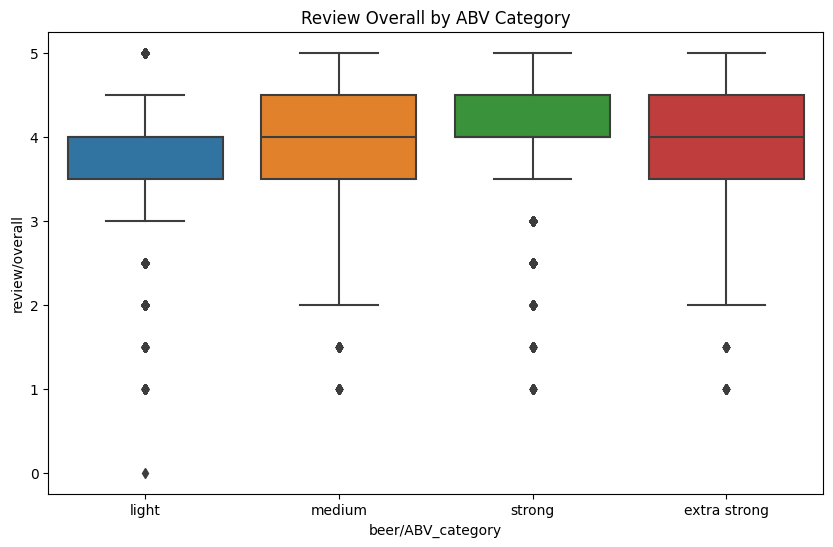

C:\Users\Alienware\miniconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


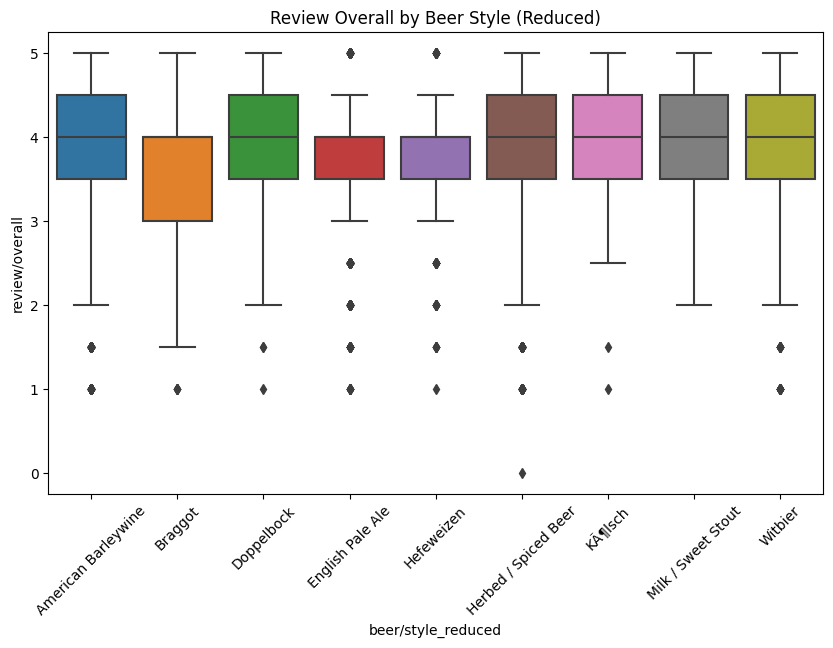

C:\Users\Alienware\miniconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


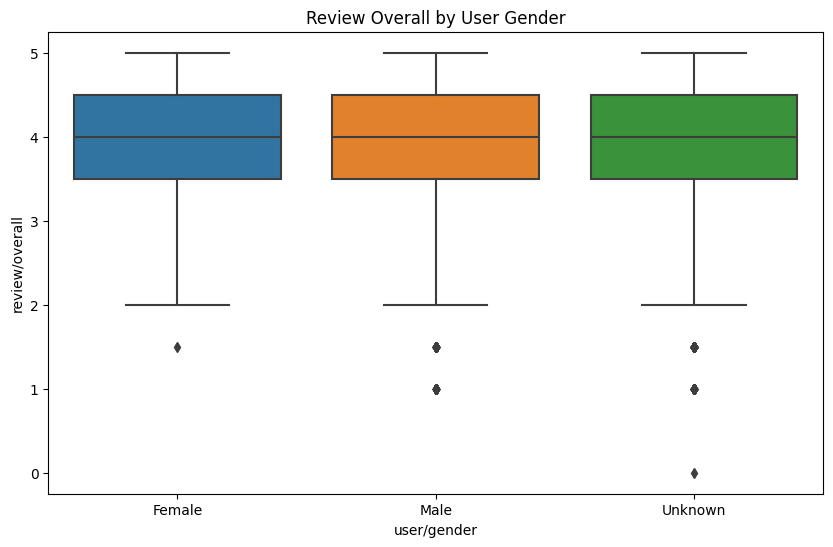

C:\Users\Alienware\miniconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


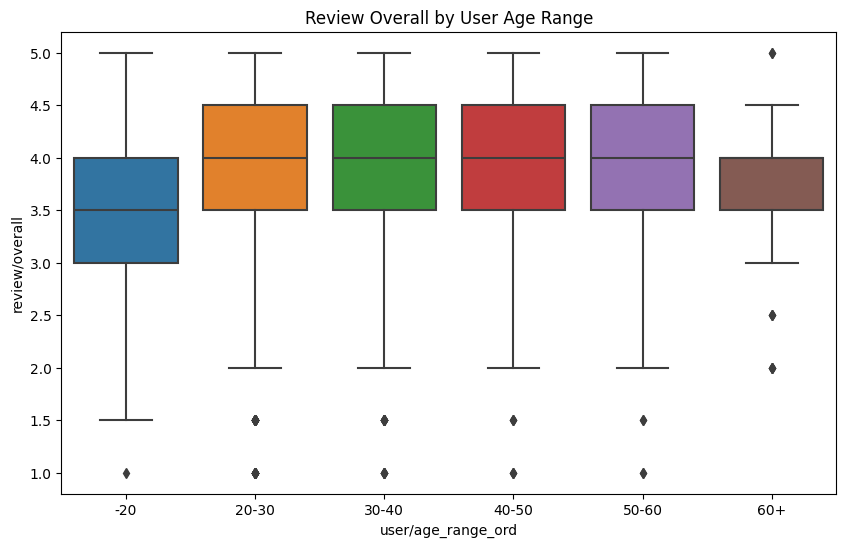

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(x='beer/ABV_category', y='review/overall', data=beer_df)
plt.title("Review Overall by ABV Category")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='beer/style_reduced', y='review/overall', data=beer_df)
plt.title("Review Overall by Beer Style (Reduced)")
plt.xticks(rotation=45)  # Rotate if style names are long
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='user/gender', y='review/overall', data=beer_df)
plt.title("Review Overall by User Gender")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='user/age_range_ord', y='review/overall', data=beer_df)
plt.title("Review Overall by User Age Range")
plt.show()


In [24]:
# use a regression model to quantify the impacts of  features ( ABV category, beer style, gender, and age range) on the overall beer rating
# Before modeling, transform categorical predictors (ordinal and nominal) into numerical values

# Ordinal: using codes
beer_df['beer_ABV_category_code'] = beer_df['beer/ABV_category'].cat.codes
beer_df['user_age_range_ord_code'] = beer_df['user/age_range_ord'].cat.codes

# nominal variables, perform one-hot encoding:
age_range_dummies = pd.get_dummies(beer_df['user/age_range_missing'], prefix='age_range_missing').astype(int)
beer_style_dummies = pd.get_dummies(beer_df['beer/style_reduced'], prefix='style').astype(int)
gender_dummies = pd.get_dummies(beer_df['user/gender'], prefix='gender').astype(int)

# combine everything into a dataframe of predictors:
X = pd.concat([beer_df[['beer_ABV_category_code', 'user_age_range_ord_code']], age_range_dummies, beer_style_dummies, gender_dummies], axis=1)

y = beer_df['review/overall']

# Drop any rows with missing values in our predictors or target:
df_model = pd.concat([X, y], axis=1).dropna()
X = df_model[X.columns]
y = df_model['review/overall']

X.shape, y.shape

((37500, 16), (37500,))

In [25]:
beer_df['user_age_range_ord_code'].value_counts(dropna=False)

user_age_range_ord_code
-1    29709
 1     4669
 2     2186
 3      570
 4      222
 0      107
 5       37
Name: count, dtype: int64

In [26]:
beer_df['user/age_range_missing'].value_counts()

user/age_range_missing
1    29709
0     7791
Name: count, dtype: int64

In [27]:
beer_df['user/gender'].value_counts()

user/gender
Unknown    22186
Male       15069
Female       245
Name: count, dtype: int64

In [28]:
print(X.dtypes)

print(y.dtype)

beer_ABV_category_code         int8
user_age_range_ord_code        int8
age_range_missing_0           int32
age_range_missing_1           int32
style_American Barleywine     int32
style_Braggot                 int32
style_Doppelbock              int32
style_English Pale Ale        int32
style_Hefeweizen              int32
style_Herbed / Spiced Beer    int32
style_KÃ¶lsch                 int32
style_Milk / Sweet Stout      int32
style_Witbier                 int32
gender_Female                 int32
gender_Male                   int32
gender_Unknown                int32
dtype: object
float64


C:\Users\Alienware\miniconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


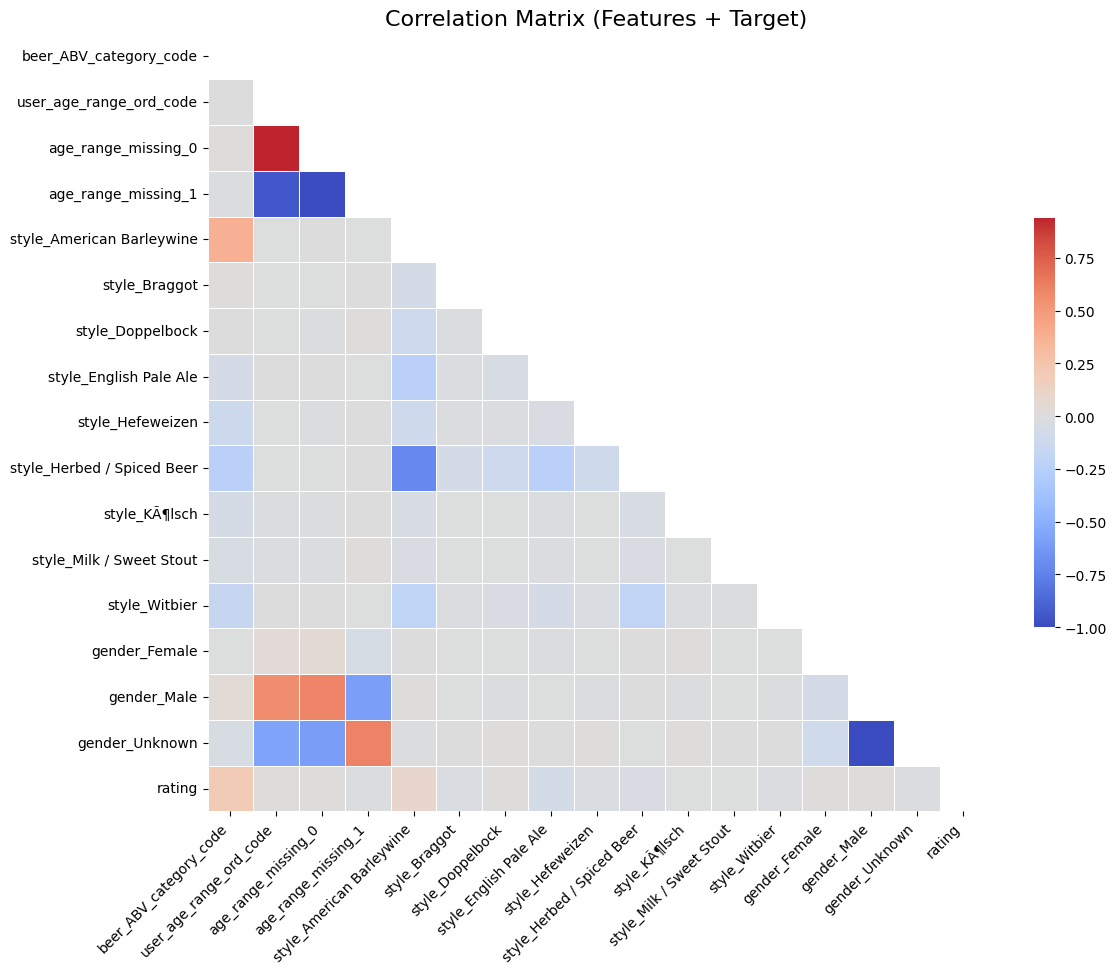

In [29]:
# Combine features and target
combined_df = pd.concat([X, y.rename('rating')], axis=1)

# Calculate the correlation matrix
corr_matrix = combined_df.corr()

# Generate a mask for the upper triangle (optional, to reduce redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure
plt.figure(figsize=(12, 10))

# Plot the heatmap with the target included
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot_kws={"size": 10})

plt.title("Correlation Matrix (Features + Target)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [30]:
'''

the rating only shows a small positive correlation with the ABV_category_code, plus some very small negative correlations with some beer style

the strong positive or negative correlation within the features indicate indicate a multicollinarity issue

'''

'\n\nthe rating only shows a small positive correlation with the ABV_category_code, plus some very small negative correlations with some beer style\n\nthe strong positive or negative correlation within the features indicate indicate a multicollinarity issue\n\n'

In [31]:
# Add a constant (intercept)
X_const = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression model:
model = sm.OLS(y, X_const).fit()

# View a summary of the model that includes coefficients, p-values, and R-squared:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         review/overall   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     141.5
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:28:29   Log-Likelihood:                -38960.
No. Observations:               37500   AIC:                         7.795e+04
Df Residuals:                   37486   BIC:                         7.807e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
'''

the model explains only about 4.7% of the variation in beer ratings

the beer ABV category is significant (each step up increases the rating by about 0.13). 

many other coefficients are extremely large, which can be a sign of multicollinearity

user_age_range_ord_code coefficient in a more appropriate range, but not statistically significal 

*** next steps: *** 

consider to use get_dummies over the age_ranges, and not ordinal codes,
as I noticed that both young and old people tend to write worse reviews than the medium aged people

tune the fuzzy matching, in order to select a different more appropriate number of style categories

improve features selection, including only features with lower correlation
(eg use drop_first=True while creading dummies categories, to avoid correlations within the same features categories)

add the calculated reduced category column for the breweries id

'''

'\n\nthe model explains only about 4.7% of the variation in beer ratings\n\nthe beer ABV category is significant (each step up increases the rating by about 0.13). \n\nmany other coefficients are extremely large, which can be a sign of multicollinearity\n\nuser_age_range_ord_code coefficient in a more appropriate range, but not statistically significal \n\n*** next steps: *** \n\nconsider to use get_dummies over the age_ranges, and not ordinal codes,\nas I noticed that both young and old people tend to write worse reviews than the medium aged people\n\ntune the fuzzy matching, in order to select a different more appropriate number of style categories\n\nimprove features selection, including only features with lower correlation\n(eg use drop_first=True while creading dummies categories, to avoid correlations within the same features categories)\n\nadd the calculated reduced category column for the breweries id\n\n'

In [33]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit a Random Forest model:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance_df)


                       feature  importance
0       beer_ABV_category_code    0.649268
1      user_age_range_ord_code    0.085429
4    style_American Barleywine    0.062372
7       style_English Pale Ale    0.044167
5                style_Braggot    0.024949
6             style_Doppelbock    0.020950
15              gender_Unknown    0.019053
12               style_Witbier    0.018292
13               gender_Female    0.017556
14                 gender_Male    0.016399
9   style_Herbed / Spiced Beer    0.011683
3          age_range_missing_1    0.009471
2          age_range_missing_0    0.008512
8             style_Hefeweizen    0.006245
10               style_KÃ¶lsch    0.003002
11    style_Milk / Sweet Stout    0.002651


In [34]:
# create another field with the user sentiment extracted from the text review
# VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool available in NLTK. 
# it relies on a curated dictionary of words and heuristic rules to detect sentiment in text (simpler than transformers and appropriate for review text)

analyzer = SentimentIntensityAnalyzer()

def extract_rating(text):
    """
    Extract a sentiment-based rating from a text review.
    Uses the VADER compound score (range [-1, 1]) and rescales it to [0, 5] (to make it consistent with the other rating fields.
    """
    scores = analyzer.polarity_scores(text)
    # It outputs a dictionary with scores like "neg", "neu", "pos", and "compound"
    compound = scores['compound']  # compound score ranges from -1 (most negative) to +1 (most positive)
    # Re-scale compound to a 0-5 rating:
    rating = (compound + 1) * 2.5
    return rating

# Apply the extraction function to the review text.
beer_df['review/text_score'] = beer_df['review/text'].apply(lambda x: extract_rating(x) if isinstance(x, str) else None)
#drop the text field
beer_df.drop('review/text', axis=1, inplace=True)
beer_df

,beer/ABV,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,user/gender,user/profileName,review/datetime,user/age_atReview,user/age_range,beer/style_reduced,beer/ABV_category,user/age_range_missing,user/age_range_ord,beer_ABV_category_code,user_age_range_ord_code,review/text_score
index,,,,,,,,,,,,,,,,,,,,,
40163,5.00,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Unknown,RblWthACoz,2008-12-16 03:38:10,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,2.56450
8135,11.00,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,Unknown,BeerSox,2008-08-08 23:38:58,NaN,NaN,American Barleywine,extra strong,1,NaN,3,-1,4.84750
10529,4.70,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,Male,mschofield,2004-11-26 18:07:02,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,4.54375
44610,4.40,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,Male,molegar76,2011-06-20 01:07:05,34.0,30-40,Herbed / Spiced Beer,light,0,30-40,0,2,4.65625
37062,4.40,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,Unknown,Brewbro000,2011-03-12 06:51:48,NaN,NaN,English Pale Ale,light,1,NaN,0,-1,4.82625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35175,5.50,3268,Blackberry Scottish-Style,Fruit / Vegetable Beer,4.0,3.5,3.5,3.5,3.5,Unknown,Redrover,2008-04-10 23:56:01,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,4.67575
23666,8.50,1199,Founders Dirty Bastard,Scotch Ale / Wee Heavy,4.5,4.0,3.5,4.5,4.5,Unknown,jmerloni,2010-01-10 05:45:14,NaN,NaN,Herbed / Spiced Beer,strong,1,NaN,2,-1,4.98650
47720,4.75,394,Stoudt's Fest,MÃ¤rzen / Oktoberfest,4.0,3.5,4.0,4.5,4.0,Unknown,UncleJimbo,2003-10-25 01:03:36,NaN,NaN,American Barleywine,light,1,NaN,0,-1,4.79875


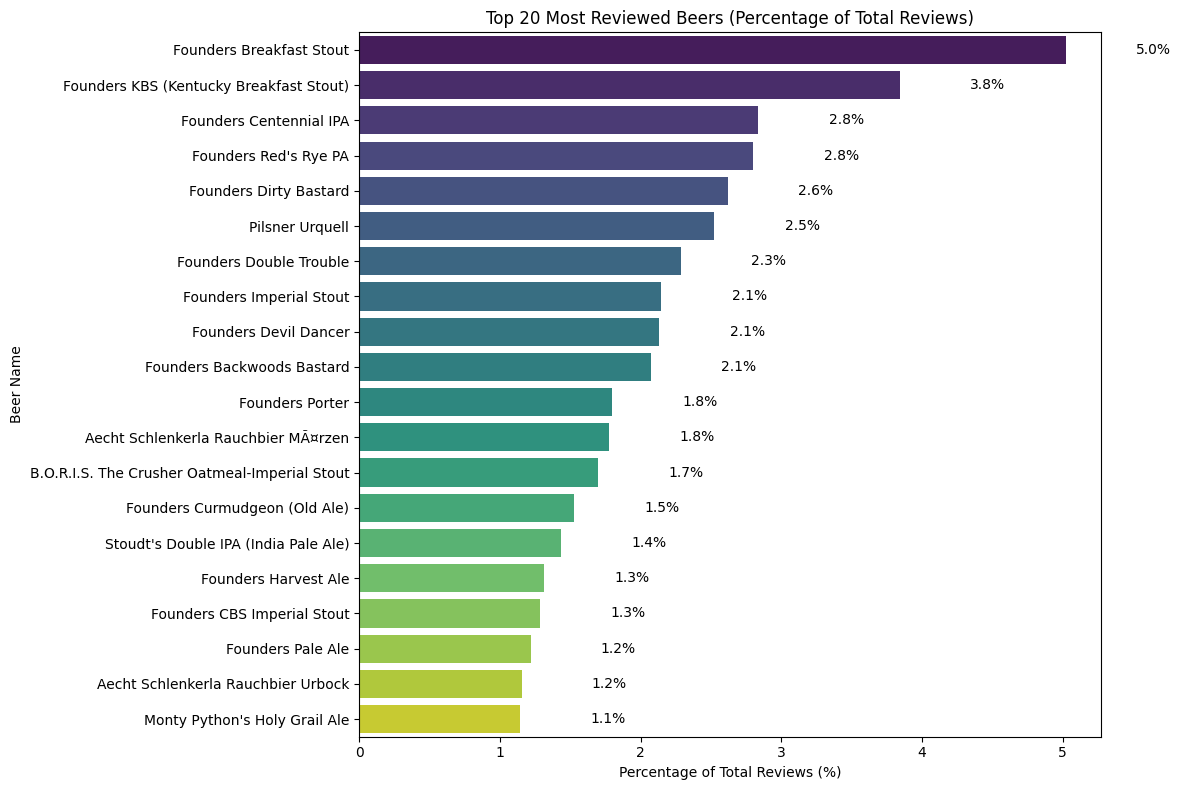

In [35]:
# If you had a beer store, what beers would you stock up?
# I'm going to check the most reviewed beers, besides the best reviewed ones

# Order beers by the number of reviews (most reviewed first)
# Compute the top 20 most reviewed beers as counts
top_20_counts = beer_df['beer/name'].value_counts().head(20)

# Calculate the total number of reviews
total_reviews = len(beer_df)

# Compute percentages
top_20_percentages = top_20_counts / total_reviews * 100

# Create a horizontal bar plot using the percentage values
plt.figure(figsize=(12,8))
ax = sns.barplot(x=top_20_percentages.values, y=top_20_percentages.index, palette="viridis")

# Set labels and title
plt.xlabel("Percentage of Total Reviews (%)")
plt.ylabel("Beer Name")
plt.title("Top 20 Most Reviewed Beers (Percentage of Total Reviews)")

# Annotate each bar with the percentage value
for i, v in enumerate(top_20_percentages.values):
    ax.text(v + 0.5, i, f"{v:.1f}%", color='black', va='center')

plt.tight_layout()
plt.show()


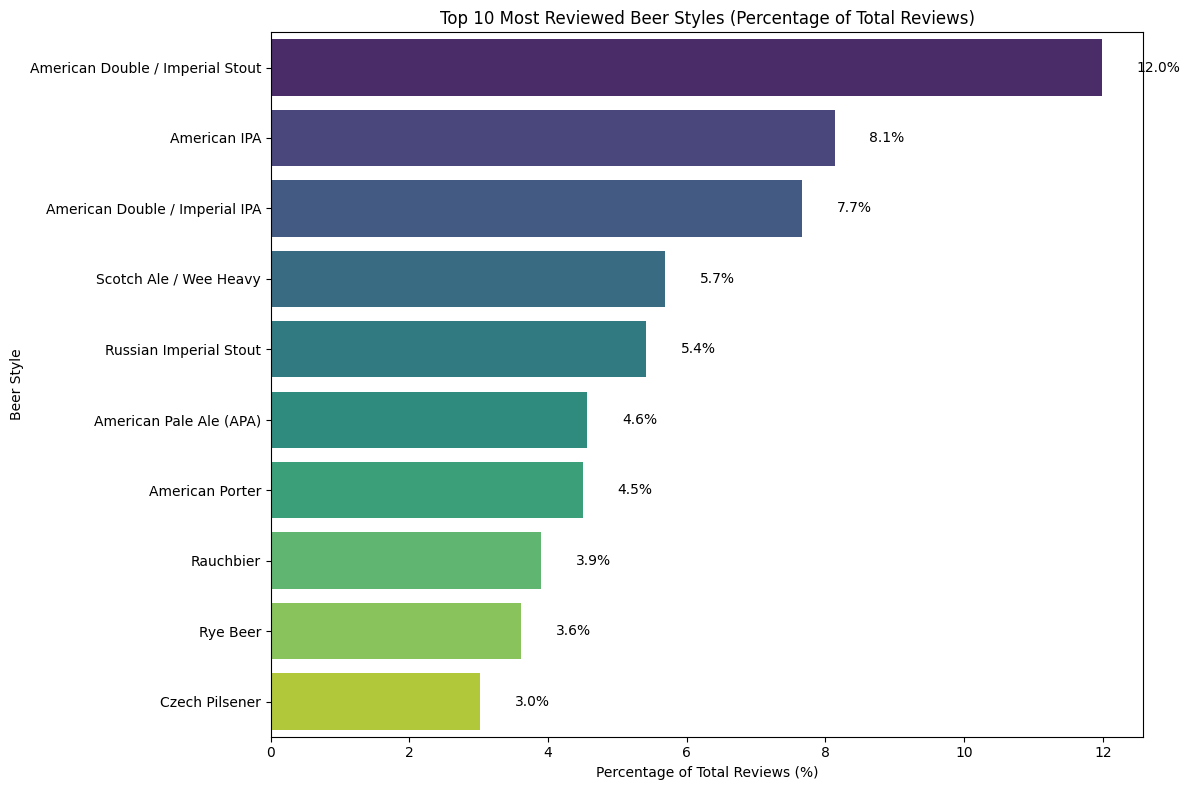

In [36]:
# Compute the top 10 most reviewed beer styles as counts
top_10_counts = beer_df['beer/style'].value_counts().head(10)

# Calculate the total number of reviews
total_reviews = len(beer_df)

# Compute percentages for each style
top_10_percentages = top_10_counts / total_reviews * 100

# Create a horizontal bar plot using the computed percentages
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_10_percentages.values, y=top_10_percentages.index, palette="viridis")

# Set labels and title
plt.xlabel("Percentage of Total Reviews (%)")
plt.ylabel("Beer Style")
plt.title("Top 10 Most Reviewed Beer Styles (Percentage of Total Reviews)")

# Annotate each bar with the percentage value
for i, perc in enumerate(top_10_percentages.values):
    ax.text(perc + 0.5, i, f"{perc:.1f}%", color='black', va='center')

plt.tight_layout()
plt.show()


In [37]:
# calculate a new field ponderated_rating as the weighted average of the specified reviews

beer_df['ponderated_rating'] = (
    0.1 * beer_df['review/appearance'] +
    0.1 * beer_df['review/aroma'] +
    0.3 * beer_df['review/overall'] +
    0.1 * beer_df['review/palate'] +
    0.1 * beer_df['review/taste'] +
    0.3 * beer_df['review/text_score']
)


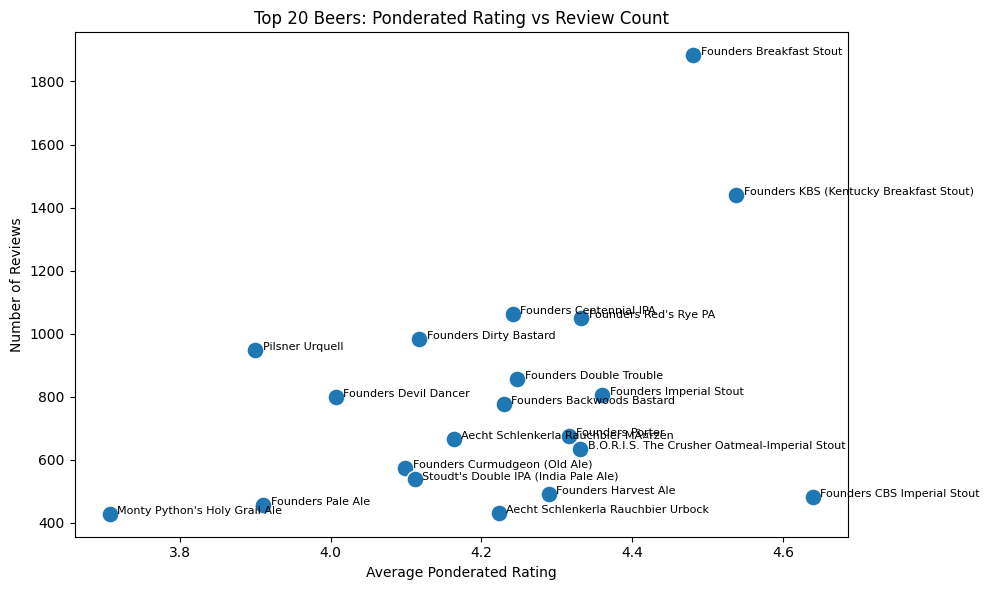

,beer/name,ponderated_rating,review_count
571,Founders Breakfast Stout,4.480595,1883
615,Founders KBS (Kentucky Breakfast Stout),4.538232,1441
575,Founders Centennial IPA,4.241549,1064
638,Founders Red's Rye PA,4.332372,1051
589,Founders Dirty Bastard,4.117812,983
1174,Pilsner Urquell,3.900380,947
592,Founders Double Trouble,4.247269,857
614,Founders Imperial Stout,4.360427,805
588,Founders Devil Dancer,4.006961,800
548,Founders Backwoods Bastard,4.229828,778


In [38]:
# Aggregate data by beer name: calculate average ponderated rating and count of reviews
beers_grouped = beer_df.groupby("beer/name").agg({
    "ponderated_rating": "mean",
    "review/overall": "count"
}).rename(columns={"review/overall": "review_count"}).reset_index()

# Select the top 20 beers by review count
top_beers = beers_grouped.sort_values("review_count", ascending=False).head(20)

# Create a scatterplot with constant marker size
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=top_beers, x="ponderated_rating", y="review_count", s=150)
ax.set_title("Top 20 Beers: Ponderated Rating vs Review Count")
ax.set_xlabel("Average Ponderated Rating")
ax.set_ylabel("Number of Reviews")

# Annotate points with beer name
for _, row in top_beers.iterrows():
    ax.text(row["ponderated_rating"] + 0.01, row["review_count"], row["beer/name"], fontsize=8)
plt.tight_layout()
plt.show()

top_beers

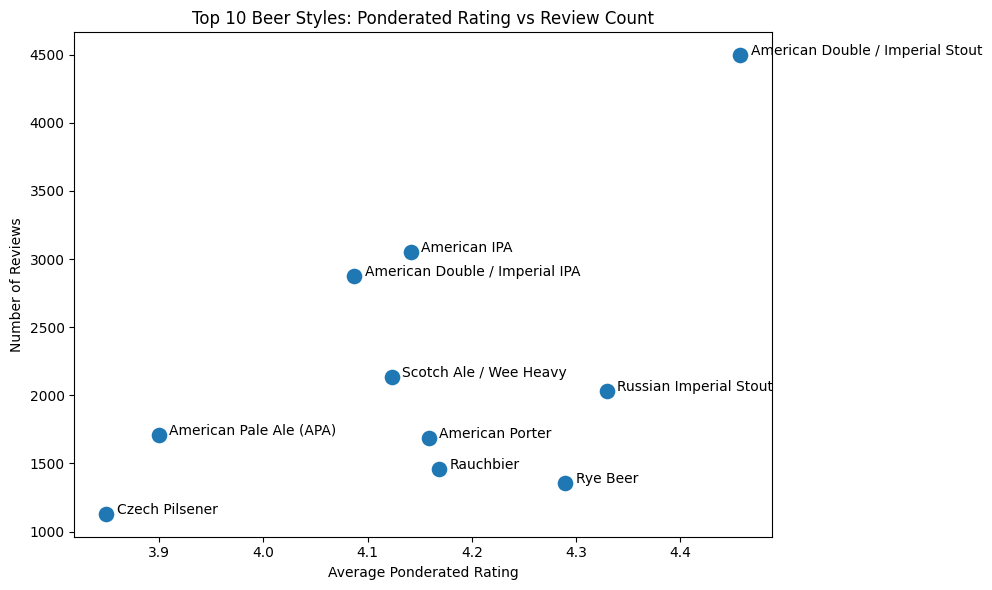

,beer/style,ponderated_rating,review_count
11,American Double / Imperial Stout,4.457492,4495
12,American IPA,4.141251,3050
9,American Double / Imperial IPA,4.087144,2872
85,Scotch Ale / Wee Heavy,4.123172,2133
81,Russian Imperial Stout,4.329390,2032
14,American Pale Ale (APA),3.900035,1711
17,American Porter,4.158668,1687
80,Rauchbier,4.168310,1462
82,Rye Beer,4.289428,1355
35,Czech Pilsener,3.849359,1131


In [39]:
# Aggregate data by beer style: calculate average ponderated rating and count of reviews
styles_grouped = beer_df.groupby("beer/style").agg({
    "ponderated_rating": "mean",
    "review/overall": "count"
}).rename(columns={"review/overall": "review_count"}).reset_index()

# Select the top 10 beer styles by review count
top_styles = styles_grouped.sort_values("review_count", ascending=False).head(10)

# Create a scatterplot with constant marker size
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=top_styles, x="ponderated_rating", y="review_count", s=150)
ax.set_title("Top 10 Beer Styles: Ponderated Rating vs Review Count")
ax.set_xlabel("Average Ponderated Rating")
ax.set_ylabel("Number of Reviews")

# Annotate points with beer style
for _, row in top_styles.iterrows():
    ax.text(row["ponderated_rating"] + 0.01, row["review_count"], row["beer/style"], fontsize=10)
plt.tight_layout()
plt.show()

top_styles


In [40]:
'''
I filtered for beers and styles with high review counts because the reliability of an average rating depends on the sample size. 
A product with a handful of reviews might have an extreme score by chance, 
whereas a high review count indicates that the average score is more representative of overall user sentiment. 
By ensuring that there are plenty of reviews first, we can confidently rely on the subsequent rating comparison to identify truly "best" beers or styles.
'''

'\nI filtered for beers and styles with high review counts because the reliability of an average rating depends on the sample size. \nA product with a handful of reviews might have an extreme score by chance, \nwhereas a high review count indicates that the average score is more representative of overall user sentiment. \nBy ensuring that there are plenty of reviews first, we can confidently rely on the subsequent rating comparison to identify truly "best" beers or styles.\n'

In [41]:
# Count the number of reviews for each brewery using their ID
brewery_counts = beer_df['beer/brewerId'].value_counts()

# Create a new column 'brewery_reduced': if the count for a given brewery is above 1000, keep the brewery ID; otherwise, use 'other'
beer_df['brewery_reduced'] = beer_df['beer/brewerId'].apply(
    lambda x: x if brewery_counts[x] > 1000 else 'other'
)

beer_df[['beer/brewerId', 'brewery_reduced']].head()


,beer/brewerId,brewery_reduced
index,,
40163,14338,other
8135,395,395
10529,365,365
44610,1,1
37062,1417,other


In [42]:
beer_df

,beer/ABV,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,user/gender,user/profileName,review/datetime,user/age_atReview,user/age_range,beer/style_reduced,beer/ABV_category,user/age_range_missing,user/age_range_ord,beer_ABV_category_code,user_age_range_ord_code,review/text_score,ponderated_rating,brewery_reduced
index,,,,,,,,,,,,,,,,,,,,,,,
40163,5.00,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Unknown,RblWthACoz,2008-12-16 03:38:10,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,2.56450,3.569350,other
8135,11.00,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,Unknown,BeerSox,2008-08-08 23:38:58,NaN,NaN,American Barleywine,extra strong,1,NaN,3,-1,4.84750,3.904250,395
10529,4.70,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,Male,mschofield,2004-11-26 18:07:02,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,4.54375,3.863125,365
44610,4.40,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,Male,molegar76,2011-06-20 01:07:05,34.0,30-40,Herbed / Spiced Beer,light,0,30-40,0,2,4.65625,3.346875,1
37062,4.40,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,Unknown,Brewbro000,2011-03-12 06:51:48,NaN,NaN,English Pale Ale,light,1,NaN,0,-1,4.82625,3.647875,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35175,5.50,3268,Blackberry Scottish-Style,Fruit / Vegetable Beer,4.0,3.5,3.5,3.5,3.5,Unknown,Redrover,2008-04-10 23:56:01,NaN,NaN,Herbed / Spiced Beer,light,1,NaN,0,-1,4.67575,3.902725,3268
23666,8.50,1199,Founders Dirty Bastard,Scotch Ale / Wee Heavy,4.5,4.0,3.5,4.5,4.5,Unknown,jmerloni,2010-01-10 05:45:14,NaN,NaN,Herbed / Spiced Beer,strong,1,NaN,2,-1,4.98650,4.295950,1199
47720,4.75,394,Stoudt's Fest,MÃ¤rzen / Oktoberfest,4.0,3.5,4.0,4.5,4.0,Unknown,UncleJimbo,2003-10-25 01:03:36,NaN,NaN,American Barleywine,light,1,NaN,0,-1,4.79875,4.239625,394


In [43]:
# How would you go predicting future ratings for a new beer

# Create dummy categories for top breweries
brewery_dummies = pd.get_dummies(beer_df['brewery_reduced'], prefix='brewery').astype(int)

# Create dummy categories for age ranges (before we used the ordinal categories, now I try to use the nominal ones)
beer_df['user/age_range'] = beer_df['user/age_range'].cat.add_categories('unknown')
beer_df['user/age_range'] = beer_df['user/age_range'].fillna('unknown')
age_range_dummies = pd.get_dummies(beer_df['user/age_range'], prefix='age_range').astype(int)


X = pd.concat([beer_df['beer_ABV_category_code'], brewery_dummies, age_range_dummies, beer_style_dummies, gender_dummies], axis=1)
y = beer_df.ponderated_rating
X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 40163 to 23758
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   beer_ABV_category_code      37500 non-null  int8 
 1   brewery_1                   37500 non-null  int32
 2   brewery_263                 37500 non-null  int32
 3   brewery_365                 37500 non-null  int32
 4   brewery_394                 37500 non-null  int32
 5   brewery_395                 37500 non-null  int32
 6   brewery_1199                37500 non-null  int32
 7   brewery_3268                37500 non-null  int32
 8   brewery_14879               37500 non-null  int32
 9   brewery_other               37500 non-null  int32
 10  age_range_-20               37500 non-null  int32
 11  age_range_20-30             37500 non-null  int32
 12  age_range_30-40             37500 non-null  int32
 13  age_range_40-50             37500 non-null  int32
 14  age_ran

(None, None)

In [44]:
# Remove rows where the target is missing (only ten target records are null)
mask = y.notnull()
X = X[mask]
y = y[mask]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# XGBoost Regressor.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model on the training data.
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)

# Evaluate model performance using RMSE and MAE.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("Mean Absolute Error: {:.4f}".format(mae))

Mean Squared Error: 0.3012
Root Mean Squared Error: 0.5488
Mean Absolute Error: 0.3909


In [46]:
# Initialize and Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)

# Compute Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("Mean Absolute Error: {:.4f}".format(mae))

Mean Squared Error: 0.3013
Root Mean Squared Error: 0.5489
Mean Absolute Error: 0.3912


In [ ]:
'''
results to be improved through better feature engineering, hyperparameter tuning, etc
consider applying separate analysis for different customer clusters
'''